In [8]:
#rm(list=ls())
library(magrittr)
library(dplyr)
setwd("/home/huaqingj/MyResearch/HistTrial")
#setwd("C:/Users/JINHU/Documents/ProjectCode/HistTrial")
source("utils.R")
library(parallel)

In [9]:
CI.fn <- function(errs){
  m.v <- mean(errs)
  sd.v <- sd(errs)
  se <- sd.v/sqrt(length(errs))
  low <- m.v - 1.96*se
  up <- m.v + 1.96*se
  rvs <- c(low, m.v, up)
  names(rvs) <- c("lower", "mean", "upper")
  rvs
}

### Test estimated trt eff

In [36]:
fun.est <- function(i){
    Xs <- gen.Data.Xs(n0, x.tps)
    idx0 <- sample.int(n0, size=floor(n0/2))
    Zs <- rep(1, n0)
    Zs[idx0] <- 0
    
    
    betMat <- sub.Paras.fn(Xs, betass)
    nerrs <- rnorm(n0, sd=phi0)
    Ys <- curMean.fn(Xs, Zs, betMat, b) + nerrs
    data <- cbind(Ys, Zs, Xs)
    data <- as.data.frame(data)
    colnames(data)[1:2] <- c("Y", "Z")
    
    
    # no borrowing 
    Zs.no <- Zs
    Ys.no <- curMean.fn(Xs, Zs.no, betMat, b) + nerrs
    data.no <- cbind(Ys.no, Zs.no, Xs)
    data.no <- as.data.frame(data.no)
    colnames(data.no)[1:2] <- c("Y", "Z")
    
    for (j in (n0+1):N){
        cx <- unlist(gen.Data.Xs(1, x.tps))
        
        # H <- diag(c(bw.nrd(data$X1), bw.nrd(data$X2), bw.nrd(data$X3), bw.nrd(data$X4)))
        alpMat <- sub.Paras.fn(Xs, alpss)
        Theta0s <- curMean.fn(Xs, Zs, alpMat, b=0)
        res <- info.est.fn(Theta0s, data, H, lam)
        res0 <- info.est.fn(Theta0s, data, H, lam, is.borrow=FALSE)
        
        var.info <- post.var.mu0.fn(cx, res)
        var.ref <- post.var.mu0.fn(cx, res0)
        R <- var.ref/var.info
        ass.res <- RPS.design(cx, data[, 3:6], data$Z, hs, R)
        ass.res.no <- RPS.design(cx, data[, 3:6], data.no$Z, hs, R=1)
        # ass.res <- RBC.design(cx, data[, 3:6], data$Z, hs, R)
        
        Xs <- rbind(Xs, cx)
        Zs <- c(Zs, ass.res$grp-1)
        Zs.no <- c(Zs.no, ass.res.no$grp-1)
        
        curN <- dim(Xs)[1]
        curBetMat <- sub.Paras.fn(Xs[curN, ], betass)
        nerr <- rnorm(1, sd=phi0)
        Y <- curMean.fn(Xs[curN, ], Zs[curN], curBetMat, b) + nerr
        Ys <- c(Ys, Y)
        data <- cbind(Ys, Zs, Xs)
        data <- as.data.frame(data)
        colnames(data)[1:2] <- c("Y", "Z")
        
        Y.no <- curMean.fn(Xs[curN, ], Zs.no[curN], curBetMat, b) + nerr
        Ys.no <- c(Ys.no, Y.no)
        data.no <- cbind(Ys.no, Zs.no, Xs)
        data.no <- as.data.frame(data.no)
        colnames(data.no)[1:2] <- c("Y", "Z")
        
        
    }
    
    alpMat <- sub.Paras.fn(Xs, alpss)
    Theta0s <- curMean.fn(Xs, Zs, alpMat, b=0)
    res <- info.est.fn(Theta0s, data, H, lam)
    res.no <- info.est.fn(Theta0s, data.no, H, lam, is.borrow=FALSE)
    
    res.mu1 <- mu1.est.fn(data$Y, data, H)
    res.no.mu1 <- mu1.est.fn(data.no$Y, data.no, H)
    trt.eff <- mean(mu1.efn(as.matrix(Xs), res.mu1)) -  mean(mu0.efn(as.matrix(Xs), res));trt.eff
    trt.eff.no <- mean(mu1.efn(as.matrix(Xs), res.no.mu1)) -  mean(mu0.efn(as.matrix(Xs), res.no));trt.eff.no
    c(trt.eff, trt.eff.no)
}

In [148]:
# parameters for current data 
betass <- list(
              para1=c(2, 1, -1, 3, -2), 
              para2=c(3, 1, 2, 4, 2), 
              para3=c(0, -1, -1, 3, 2), 
              para4=c(2, 0, -1, 4, -2)
                  )

# parameters for historical data
alpss <-  list(para1=c(2, 1, -1, 3, -2), 
             para2=c(3, 1, 2, 4, 2), 
             para3=c(0, -1, -1, 3, 2)-2, 
             para4=c(2, 0, -1, 4, -2) )
b <- 2
phi0 = phi1 = 5
N <- 50 # total sample size
# parameters
lam <- 0.1
hs <- rep(2.1, 4)
x.tps <- c(2, 2, "c", "c")
#x.tps <- c(2, 2, 2, 2)

tXs <- gen.Data.Xs(1000, x.tps)
H <- diag(c(0.1, 0.1, 0.1, 0.1)/2)

# initial dataset
n0 <- 20

In [149]:
nSimu <- 100
trt.effs <- mclapply(1:nSimu, fun.est, mc.cores=6)

In [150]:
idxs <- sapply(1:nSimu, function(i){is.vector(trt.effs[[i]])})
trt.effs <- trt.effs[idxs]

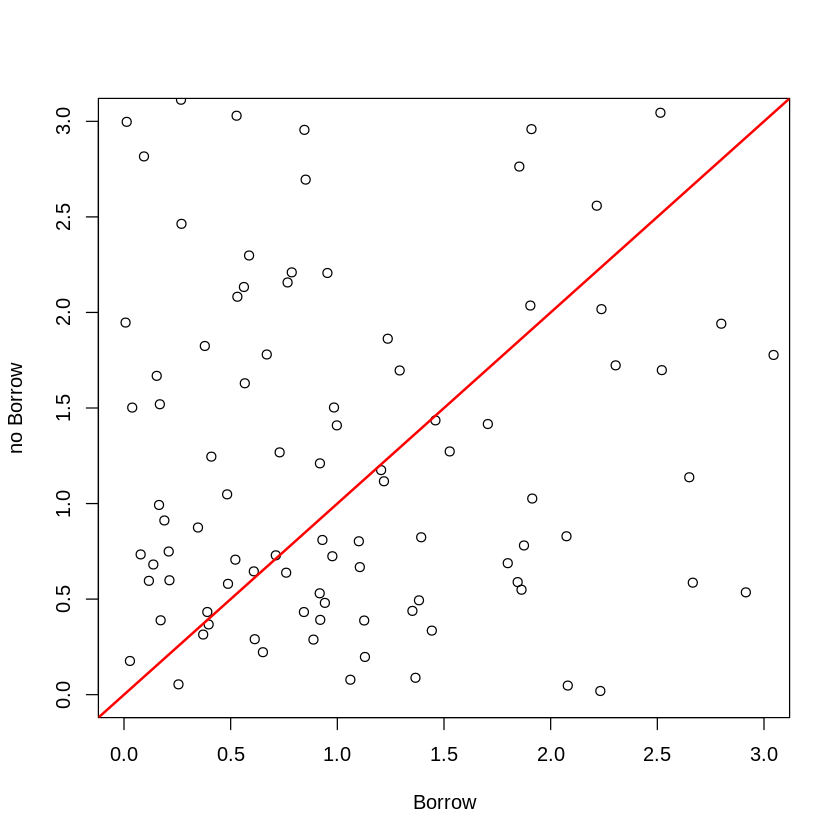

In [151]:
trt.effs.mat <- do.call(rbind, trt.effs)
errs <- abs(trt.effs.mat - b)
plot(errs[, 1], errs[, 2], xlim=c(0, 3), ylim=c(0, 3), ylab="no Borrow", xlab="Borrow")
abline(a=0, b=1, col=2, lwd=2)

In [152]:
rbind(CI.fn(errs[, 1]), CI.fn(errs[, 2]))

lower,mean,upper
1.030507,1.230523,1.430539
1.141085,1.334085,1.527085


In [153]:
mean(errs[, 1] < errs[, 2])

[1] 0.5

In [154]:
c(median(errs[, 1]), median(errs[, 2]))

[1] 0.9358528 1.0824059

### Power size 

In [10]:
fun.test <- function(i){
    Xs <- gen.Data.Xs(n0, x.tps)
    idx0 <- sample.int(n0, size=floor(n0/2))
    Zs <- rep(1, n0)
    Zs[idx0] <- 0
    
    
    betMat <- sub.Paras.fn(Xs, betass)
    nerrs <- rnorm(n0, sd=phi0)
    Ys <- curMean.fn(Xs, Zs, betMat, b) + nerrs
    data <- cbind(Ys, Zs, Xs)
    data <- as.data.frame(data)
    colnames(data)[1:2] <- c("Y", "Z")
    
    
    # no borrowing 
    Zs.no <- Zs
    Ys.no <- curMean.fn(Xs, Zs.no, betMat, b) + nerrs
    data.no <- cbind(Ys.no, Zs.no, Xs)
    data.no <- as.data.frame(data.no)
    colnames(data.no)[1:2] <- c("Y", "Z")
    
    for (j in (n0+1):N){
        cx <- unlist(gen.Data.Xs(1, x.tps))
        
        # H <- diag(c(bw.nrd(data$X1), bw.nrd(data$X2), bw.nrd(data$X3), bw.nrd(data$X4)))
        alpMat <- sub.Paras.fn(Xs, alpss)
        Theta0s <- curMean.fn(Xs, Zs, alpMat, b=0)
        res <- info.est.fn(Theta0s, data, H, lam)
        res0 <- info.est.fn(Theta0s, data, H, lam, is.borrow=FALSE)
        
        var.info <- post.var.mu0.fn(cx, res)
        var.ref <- post.var.mu0.fn(cx, res0)
        R <- var.ref/var.info
        ass.res <- RPS.design(cx, data[, 3:6], data$Z, hs, R)
        ass.res.no <- RPS.design(cx, data[, 3:6], data.no$Z, hs, R=1)
        # ass.res <- RBC.design(cx, data[, 3:6], data$Z, hs, R)
        
        Xs <- rbind(Xs, cx)
        Zs <- c(Zs, ass.res$grp-1)
        Zs.no <- c(Zs.no, ass.res.no$grp-1)
        
        curN <- dim(Xs)[1]
        curBetMat <- sub.Paras.fn(Xs[curN, ], betass)
        nerr <- rnorm(1, sd=phi0)
        Y <- curMean.fn(Xs[curN, ], Zs[curN], curBetMat, b) + nerr
        Ys <- c(Ys, Y)
        data <- cbind(Ys, Zs, Xs)
        data <- as.data.frame(data)
        colnames(data)[1:2] <- c("Y", "Z")
        
        Y.no <- curMean.fn(Xs[curN, ], Zs.no[curN], curBetMat, b) + nerr
        Ys.no <- c(Ys.no, Y.no)
        data.no <- cbind(Ys.no, Zs.no, Xs)
        data.no <- as.data.frame(data.no)
        colnames(data.no)[1:2] <- c("Y", "Z")
        
        
    }
    
    alpMat <- sub.Paras.fn(Xs, alpss)
    Theta0s <- curMean.fn(Xs, Zs, alpMat, b=0)
    res <- info.est.fn(Theta0s, data, H, lam)
    res.no <- info.est.fn(Theta0s, data.no, H, lam, is.borrow=FALSE)
    
    res.mu1 <- mu1.est.fn(data$Y, data, H)
    res.no.mu1 <- mu1.est.fn(data.no$Y, data.no, H)
    trt.eff <- mean(mu1.efn(as.matrix(Xs), res.mu1)) -  mean(mu0.efn(as.matrix(Xs), res))
    trt.eff.no <- mean(mu1.efn(as.matrix(Xs), res.no.mu1)) -  mean(mu0.efn(as.matrix(Xs), res.no))
    post.prob.trt <- function(i){
        sps0 <- r.postMu0(as.matrix(Xs), res)
        sps0.no <- r.postMu0(as.matrix(Xs), res.no)
        sps1 <- r.postMu1(as.matrix(Xs), res.mu1)
        sps1.no <- r.postMu1(as.matrix(Xs), res.no.mu1)
        
        sps.trt <- mean(sps1) - mean(sps0)
        sps.trt.no <- mean(sps1.no) - mean(sps0.no)
        c(sps.trt, sps.trt.no)
    }
    sps.trts <- lapply(1:M, post.prob.trt)
    
    rv <- list(mtrt=c(trt.eff, trt.eff.no), sps.trts=sps.trts)
    rv
}

In [241]:
# parameters for current data 
betass <- list(
              para1=c(2, 1, -1, 3, -2), 
              para2=c(3, 1, 2, 4, 2), 
              para3=c(0, -1, -1, 3, 2), 
              para4=c(2, 0, -1, 4, -2)
                  )

# parameters for historical data
alpss <-  list(para1=c(2, 1, -1, 3, -2), 
             para2=c(3, 1, 2, 4, 2), 
             para3=c(0, -1, -1, 3, 2), 
             para4=c(2, 0, -1, 4, -2) )
b <- 1
phi0 = phi1 = 2
N <- 100 # total sample size
# parameters
lam <- 0.1
hs <- rep(2.1, 4)
x.tps <- c(2, 2, "c", "c")
#x.tps <- c(2, 2, 2, 2)

tXs <- gen.Data.Xs(1000, x.tps)
H <- diag(c(0.1, 0.1, 0.1, 0.1)/2)

# initial dataset
n0 <- 20

# for hypothesis test
# to calculate the prob
M <- 1000

In [242]:
nSimu <- 1000
post.res <- mclapply(1:nSimu, fun.test, mc.cores=6)

In [249]:
# for hypothesis test
dlt0 <- 0.5
# eps0 and eps0.no are tuned such that the size is 0.5 
eps0 <- 0.519
eps0.no <- 0.526
# (n0, N, phi0) = (20, 50, 5): ep0s = (0.531, 0.527)
# (n0, N, phi0) = (20, 50, 10): ep0s = (0.529, 0.534)
# (n0, N, phi0) = (20, 100, 10): ep0s = (0.579, 0.571)
# (n0, N, phi0) = (20, 100, 2): ep0s = (0.519, 0.526)

In [250]:
post.fn <- function(trts){
    prob <- mean(trts > dlt0)
    prob
}

post.b.fn <- function(res){
    sps.trts <- res$sps.trts
    trtsMat <- do.call(rbind, sps.trts)
    prb <- post.fn(trtsMat[, 1])
    prb.no <- post.fn(trtsMat[, 2])
    c(prb, prb.no)
}

In [251]:
probMat <- sapply(post.res, post.b.fn)
power <- mean(probMat[1, ] > eps0)
power.no <- mean(probMat[2,] > eps0.no)
powers <- c(power, power.no)
names(powers) <- c("Borrow", "No Borrow")
powers

Borrow No Borrow 
    0.863     0.811